# EDA of DSC 20 Grades (Spring 2018)
*By [Daniel Lee](https://github.com/dleestat)*

---

## Introduction
DSC 20 (Programming and Basic Data Structures for Data Science) is an awesome data science course taught at UC San Diego. DSC 20 is taught using Python and a good portion of the course is spent building off of the concepts in its prerequisite course, DSC 10 (Principles of Data Science). This includes the use of the pandas library for big data processing. Course descriptions for DSC 10 and DSC 20 are [here](https://ucsd.edu/catalog/courses/DSC.html).

At the end of the course, grade breakdowns were released via CSV files (quite suitably). We were given a dataset. So of course, I'm going to analyze it.

We'll be analyzing student grades for the quarter I took this course, Spring Quarter 2018. Techniques we'll use include:
- **Summary and Descriptive Statistics**
- **Correlation** (between Students)
- **Prediction** (of Final Exam Scores)
    - **Linear Regression**
        - **Elastic Net**
    - **Random Forest (Regression)**

## Syllabus
Taken from the [syllabus](https://sites.google.com/a/eng.ucsd.edu/dsc20-spring-2018/), below is the grade breakdown used for the calculation of the final course grade.

>- *30% Final Exam*
- *25% Homework Assignments*
- *15% Midterm Exam*
- *15% Labs*
- *10% Final Project*
- *5% Class Participation*

**Notes:**
- Since UCSD runs on the quarter system, the course consists of 10 weeks of instruction (referred to as Week 1, Week 2, etc.). A lab and a homework assignment was assigned every week, resulting in a total of 10 lab and homework assignments. The Final Project was due at the end of Week 10. The midterm exam was held during Week 5 and the final exam after Week 10.
- Students must have scored at least a 55% on the final exam to have passed the course.
- The lowest homework score was dropped. In addition, the 10th homework assignment was optional and replaced the lowest homework score if it benefited the student.
- The lowest lab score was dropped.
- The "Class Participation" score is based on the percentage of lectures attended (monitored via iClickers). The first 6 missed lectures were dropped (i.e. not penalized for).

In [1]:
weeks = range(1,11)
final_exam_cutoff = .55

## Packages and Utilities
We'll first import and setup any relevant libraries and utilities.

In [2]:
# In alphabetical order:

from itertools import combinations  # Combinations (combinatorics)
from matplotlib.lines import Line2D

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from natsort import natsorted  # Natural sorting
import numpy as np

import pandas as pd
pd.set_option('display.precision',4)
pd.set_option('max_columns',30)
pd.set_option('max_colwidth',100)
pd.set_option('max_rows',8)

import re  # Regular expressions
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [3]:
%%javascript
/* Disable auto-scrolling of long cell output */
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Data Import and Cleaning
We'll take a look at the raw dataset `Grades.csv`, then process the dataset into the most convenient format for our analysis.

### Raw Dataset

In [4]:
df_raw = pd.read_csv('Grades.csv')
df_raw

,Secrete Code,ants_bees_score,hw1_score,hw10_score,hw2_score,hw3_score,hw4_score,hw5_score,hw6_score,hw7_score,hw8_score,hw9_score,lab01_score,lab02_score,lab03_score,lab04_score,lab05_score,lab07_score,lab08_score,lab09_score,lab10_score,lab6_score,Midterm,Final,Participation,LAB_Total,HW_Total,Weighted_Total
0,vkk236,1.08,0.78,0.8,0.86,0.90,0.96,0.86,1.00,1.00,0.80,0.88,1.0,1.0,1.0,1.0,1.0,0.1,1.0,1.0,1.0000,1.0,0.9250,1.0444,0.8889,1.0000,0.9075,0.9814
1,blcrqj,1.08,0.94,0.6,0.93,0.88,0.99,0.93,0.90,0.87,0.93,0.95,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0000,1.0,0.8375,0.9667,1.0000,1.0000,0.9312,0.9564
2,bxc522,1.08,0.97,0.0,0.84,0.91,0.99,0.93,1.00,0.92,0.99,0.96,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0000,1.0,0.9125,0.9422,1.0000,1.0000,0.9588,0.9672
3,sghvkpdq,1.00,0.99,1.0,0.68,0.86,0.84,0.88,0.96,0.96,0.41,0.83,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.8571,1.0,0.9250,0.7889,0.6667,0.9841,0.9150,0.8851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,da005706,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0000,0.2222,0.0000,0.0000,0.0111
145,da005732,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0000,1.0000,0.0000,0.0000,0.0500
146,da005687,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0000,0.7778,0.0000,0.0000,0.0389
147,da005745,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0000,0.9259,0.0000,0.0000,0.0463


The `Grades.csv` dataset (stored in `df_raw`) contains all scores of all students. Scores are given as decimals (out of 1) rather than percentages. The raw dataset is not ordered in any discernible way.

**Selected Columns:**
- `Secrete Code` contains enciphered student ID's. For privacy, names and actual student ID's are not given.
- `ants_bees_score` contains final project scores (the final project was to program "Ants Vs. SomeBees", a custom implementation of the famous Plants vs. Zombies game).
- `Weighted_Total` contains final course grades.

### Cleaning

In [5]:
# Sort by final course grade
df = df_raw.sort_values('Weighted_Total', ascending=False).reset_index(drop=True)
df.index += 1

# Condense the 20 HW and Lab score columns into 2 single columns
hw_cols   = natsorted(filter(re.compile('hw\d+_score').match, df.columns))
lab_cols  = natsorted(filter(re.compile('lab\d+_score').match, df.columns))
df['HW']  = df[hw_cols].apply(lambda row: tuple(row), axis=1)
df['Lab'] = df[lab_cols].apply(lambda row: tuple(row), axis=1)

# Select and rename columns
df = df[['Secrete Code','Weighted_Total','Final','Midterm','HW_Total','LAB_Total','ants_bees_score','Participation','HW','Lab']]
df.rename({'Secrete Code':'ID','Weighted_Total':'Total','HW_Total':'HW_Avg','LAB_Total':'Lab_Avg','ants_bees_score':'Project'}, axis=1, inplace=True)
df

,ID,Total,Final,Midterm,HW_Avg,Lab_Avg,Project,Participation,HW,Lab
1,vkb218,1.0229,1.0778,0.9750,0.9813,1.0000,1.08,1.0000,"(1.0, 0.65, 0.98, 0.99, 0.93, 0.96, 0.98, 0.96, 0.98, 1.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
2,gko011,1.0225,1.0889,0.9375,0.9888,1.0000,1.08,1.0000,"(1.0, 0.95, 0.98, 0.92, 1.0, 1.0, 0.96, 0.99, 0.98, 1.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
3,zhc195,1.0097,1.1222,0.9375,0.9295,1.0000,1.00,1.0000,"(0.82, 0.91, 0.92, 0.97, 0.96, 0.99, 0.92, 0.9259999999999999, 0.84, 0.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
4,mprxo,1.0046,1.1144,0.8875,0.9487,1.0000,1.00,1.0000,"(0.93, 0.89, 0.89, 0.97, 0.99, 1.0, 0.98, 0.86, 0.94, 0.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0)"
...,...,...,...,...,...,...,...,...,...,...
145,golx9999,0.0207,0.0000,0.0000,0.0000,0.1111,0.04,0.0000,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)"
146,svsdkzd,0.0167,0.0000,0.0000,0.0000,0.1111,0.00,0.0000,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
147,blk317,0.0167,0.0000,0.0000,0.0000,0.1111,0.00,0.0000,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
148,da005706,0.0111,0.0000,0.0000,0.0000,0.0000,0.00,0.2222,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


This new dataset (stored in `df`) is now ordered by `Total`. Row indices now reflect student rankings (starting from 1).

**Columns:**
1. `ID` contains enciphered student ID's (if you're curious, mine is `gko011`).
- `Total` contains final course grades.
- `Final` contains final exam scores.
- `Midterm` contains midterm exam scores.
- `HW_Avg` contains homework score averages.
- `Lab_Avg` contains lab score averages.
- `Project` contains final project scores.
- `Participation` contains participation scores.
- `HW` contains homework scores.
- `Lab` contains lab scores.

There is one problem. The dataset contains all students who have been enrolled in the course *at any time*. Thus, the dataset may contain students who had dropped the course. This would invalidate the scores of these students, skewing our analysis.

Unfortunately, I don't have access to the resources (e.g. class rosters) to determine which students have dropped. However, we will use our best judgement to remove these students from our dataset.

Per [UCSD Academic Senate Regulations](http://senate.ucsd.edu/Operating-Procedures/Senate-Manual/Regulations/501), students were allowed to drop the course up to the end of Week 9. Keep in mind that the final exam was held after Week 10.

Thus, let's assume:

$$\text{A student received a nonzero score on the final exam.} \implies \text{The student did not drop the course.}$$

However, the converse is not necessarily true. There is a chance that an enrolled student missed the final exam due to an emergency or oversleeping (the exam was at 8 a.m. on a Saturday).

What we can do is start at the bottom of the rankings and work our way up until we find a student with a nonzero final exam score. Then we can assume that all the students below this student have dropped and all the students above (inclusive) have not dropped.

This process is illustrated below.

In [6]:
highlight = lambda row: ['background: lightyellow' if row.name == 120 
                         else 'background: seashell' if row.name > 123
                         else 'background: honeydew' for i in row]
df.loc[118:126].style.apply(highlight, axis=1)

,ID,Total,Final,Midterm,HW_Avg,Lab_Avg,Project,Participation,HW,Lab
118,jvfkzduw,0.657,0.5678,0.9,0.4088,0.7,1,0.8889,"(0.71, 0.09, 0.61, 0.29, 0.54, 0.89, 0.14, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 1.0, 0.7, 1.0, 1.0, 0.6, 0.0, 1.0)"
119,b2pd,0.6455,0.4822,0.6125,0.65,0.9722,0.58,0.8519,"(0.65, 0.38, 0.86, 0.8, 0.0, 0.86, 0.96, 0.0, 0.69, 0.0)","(1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5714285714285714)"
120,qlo021,0.6308,0,0.975,0.8494,1,1,0.4444,"(0.815, 0.53, 0.87, 0.97, 0.92, 0.92, 0.38, 0.93, 0.84, 0.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
121,h3vdqwrv,0.6228,0.3244,0.4875,0.6825,0.8905,1,0.963,"(0.89, 0.5, 0.73, 0.73, 0.52, 0.67, 0.9, 0.16, 0.52, 0.0)","(1.0, 1.0, 1.0, 1.0, 0.7, 1.0, 1.0, 0.6, 0.3, 0.7142857142857143)"
122,clt016,0.6132,0.3033,0.7375,0.6475,0.9194,0.84,0.5556,"(0.62, 0.43, 0.69, 0.78, 0.79, 0.93, 0.24, 0.0, 0.7, 0.0)","(0.4, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0)"
123,uxihl,0.5687,0.2667,0.2625,0.7375,0.8778,1,0.6667,"(0.85, 0.1664, 0.73, 0.7, 0.89, 0.95, 0.22, 0.63, 0.93, 0.0)","(0.4, 1.0, 0.5, 1.0, 0.7, 1.0, 0.7, 1.0, 1.0, 1.0)"
124,phw016,0.3391,0,0.6125,0.4888,0.8333,0,0,"(0.83, 0.43, 0.17, 0.9, 0.71, 0.0, 0.39, 0.48, 0.0, 0.0)","(1.0, 1.0, 1.0, 0.2, 0.4, 1.0, 1.0, 1.0, 0.9, 0.0)"
125,bzfkhq,0.2712,0,0.5875,0.4475,0.475,0,0,"(0.87, 0.38, 0.74, 0.89, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 1.0, 0.875, 1.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0)"
126,vwdnhjdp,0.1932,0,0.3875,0.3719,0.1199,0,0.4815,"(0.775, 0.48, 0.81, 0.91, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.4, 0.4545454545454545, 0.125, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


Above is an excerpt of the dataset with the 118th to 126th ranked students.

Here, students `phw016` and below (highlighted red) received a zero final exam score. `uxihl` is the lowest ranked student who received a nonzero final exam score. Thus, we assume that students `phw016` and below have dropped and students `uxihl` and above (highlighted green) have not dropped. Although `qlo021` (highlighted yellow) received a zero final exam score, we also assume that the student had not dropped since his/her ranking is above `uxihl`'s (in fact, `qlo021` is the only student above `uxihl` with a zero final exam score).

In [7]:
df.loc[df['Final']==0].head(1)

,ID,Total,Final,Midterm,HW_Avg,Lab_Avg,Project,Participation,HW,Lab
120,qlo021,0.6308,0.0,0.975,0.8494,1.0,1.0,0.4444,"(0.815, 0.53, 0.87, 0.97, 0.92, 0.92, 0.38, 0.93, 0.84, 0.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"


We can validate our process on a case-by-case basis. All of the red-highlighted students received zeroes on their project score as well as their last few homework and lab scores, suggesting the students had dropped before these assignments were due. This pattern is not apparent in the green and yellow-highlighted students. Looking at `qlo021`, we can see that the student had received high midterm and assignment scores, suggesting that he/she had missed the final exam due to an emergency or oversleeping and not because he/she had dropped (a student who had received strong grades and had completed the last few assignments is very unlikely to have dropped). Therefore, our process appears to be effective.

We'll now apply this process to our dataset.

In [8]:
# Remove students who had dropped
df = df.iloc[:-tuple(df['Final'] > 0)[::-1].index(True)]
df

,ID,Total,Final,Midterm,HW_Avg,Lab_Avg,Project,Participation,HW,Lab
1,vkb218,1.0229,1.0778,0.9750,0.9813,1.0000,1.08,1.0000,"(1.0, 0.65, 0.98, 0.99, 0.93, 0.96, 0.98, 0.96, 0.98, 1.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
2,gko011,1.0225,1.0889,0.9375,0.9888,1.0000,1.08,1.0000,"(1.0, 0.95, 0.98, 0.92, 1.0, 1.0, 0.96, 0.99, 0.98, 1.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
3,zhc195,1.0097,1.1222,0.9375,0.9295,1.0000,1.00,1.0000,"(0.82, 0.91, 0.92, 0.97, 0.96, 0.99, 0.92, 0.9259999999999999, 0.84, 0.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
4,mprxo,1.0046,1.1144,0.8875,0.9487,1.0000,1.00,1.0000,"(0.93, 0.89, 0.89, 0.97, 0.99, 1.0, 0.98, 0.86, 0.94, 0.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0)"
...,...,...,...,...,...,...,...,...,...,...
120,qlo021,0.6308,0.0000,0.9750,0.8494,1.0000,1.00,0.4444,"(0.815, 0.53, 0.87, 0.97, 0.92, 0.92, 0.38, 0.93, 0.84, 0.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
121,h3vdqwrv,0.6228,0.3244,0.4875,0.6825,0.8905,1.00,0.9630,"(0.89, 0.5, 0.73, 0.73, 0.52, 0.67, 0.9, 0.16, 0.52, 0.0)","(1.0, 1.0, 1.0, 1.0, 0.7, 1.0, 1.0, 0.6, 0.3, 0.7142857142857143)"
122,clt016,0.6132,0.3033,0.7375,0.6475,0.9194,0.84,0.5556,"(0.62, 0.43, 0.69, 0.78, 0.79, 0.93, 0.24, 0.0, 0.7, 0.0)","(0.4, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0)"
123,uxihl,0.5687,0.2667,0.2625,0.7375,0.8778,1.00,0.6667,"(0.85, 0.1664, 0.73, 0.7, 0.89, 0.95, 0.22, 0.63, 0.93, 0.0)","(0.4, 1.0, 0.5, 1.0, 0.7, 1.0, 0.7, 1.0, 1.0, 1.0)"


The dataset now contains 123 instead of 148 students after removing the 25 students who had dropped as per our process. Our dataset is now ready for analysis.

In [9]:
n = df.shape[0]  # Number of students in the final, cleaned dataset

## Summary and Descriptive Statistics

In [10]:
df.describe()

,Total,Final,Midterm,HW_Avg,Lab_Avg,Project,Participation
count,123.0000,123.0000,123.0000,123.0000,123.0000,123.0000,123.0000
mean,0.8523,0.7751,0.7660,0.8588,0.9786,1.0091,0.8485
std,0.0994,0.1983,0.1647,0.1109,0.0475,0.1365,0.2497
min,0.5687,0.0000,0.0000,0.4006,0.7000,0.3000,0.0000
25%,0.7954,0.6633,0.6750,0.8062,0.9841,1.0000,0.7963
50%,0.8604,0.7889,0.8000,0.8975,1.0000,1.0800,0.9630
75%,0.9333,0.9183,0.8875,0.9350,1.0000,1.0800,1.0000
max,1.0229,1.1222,0.9750,0.9925,1.0000,1.0800,1.0000


Note: Some scores are above 1.0 due to extra credit.

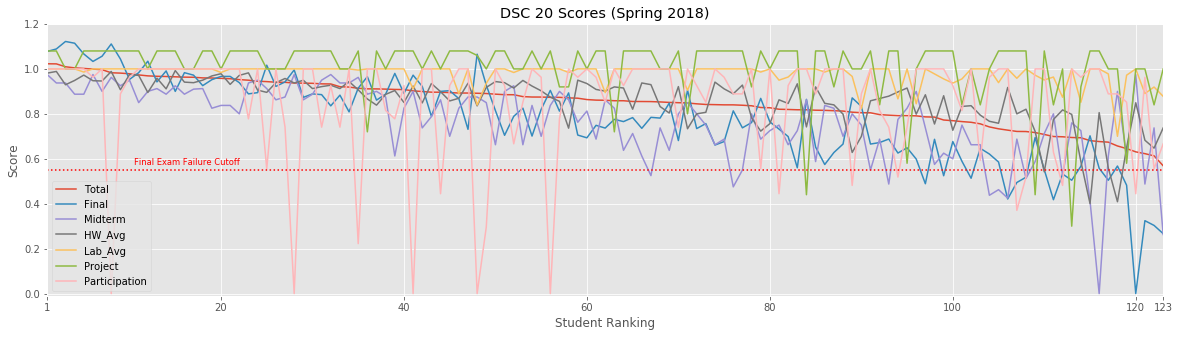

In [11]:
df.plot(figsize=(20,5))
plt.title('DSC 20 Scores (Spring 2018)')
plt.xlabel('Student Ranking')
plt.ylabel('Score')
plt.axhline(final_exam_cutoff, c='r', ls=':', lw=1.5)
plt.text(10.5, .575, 'Final Exam Failure Cutoff', color='r', size='small')
plt.axis([1,n,-.01,1.2])
plt.xticks(list(range(20,n,20)) + [1,n]);

Unsurprisingly, we can see a downward trend in most scores as student ranking descends. However, notice that `Participation` scores vary wildly with rankings (i.e. `Total`). We'll later see that there is almost no correlation between `Participation` and `Total`.

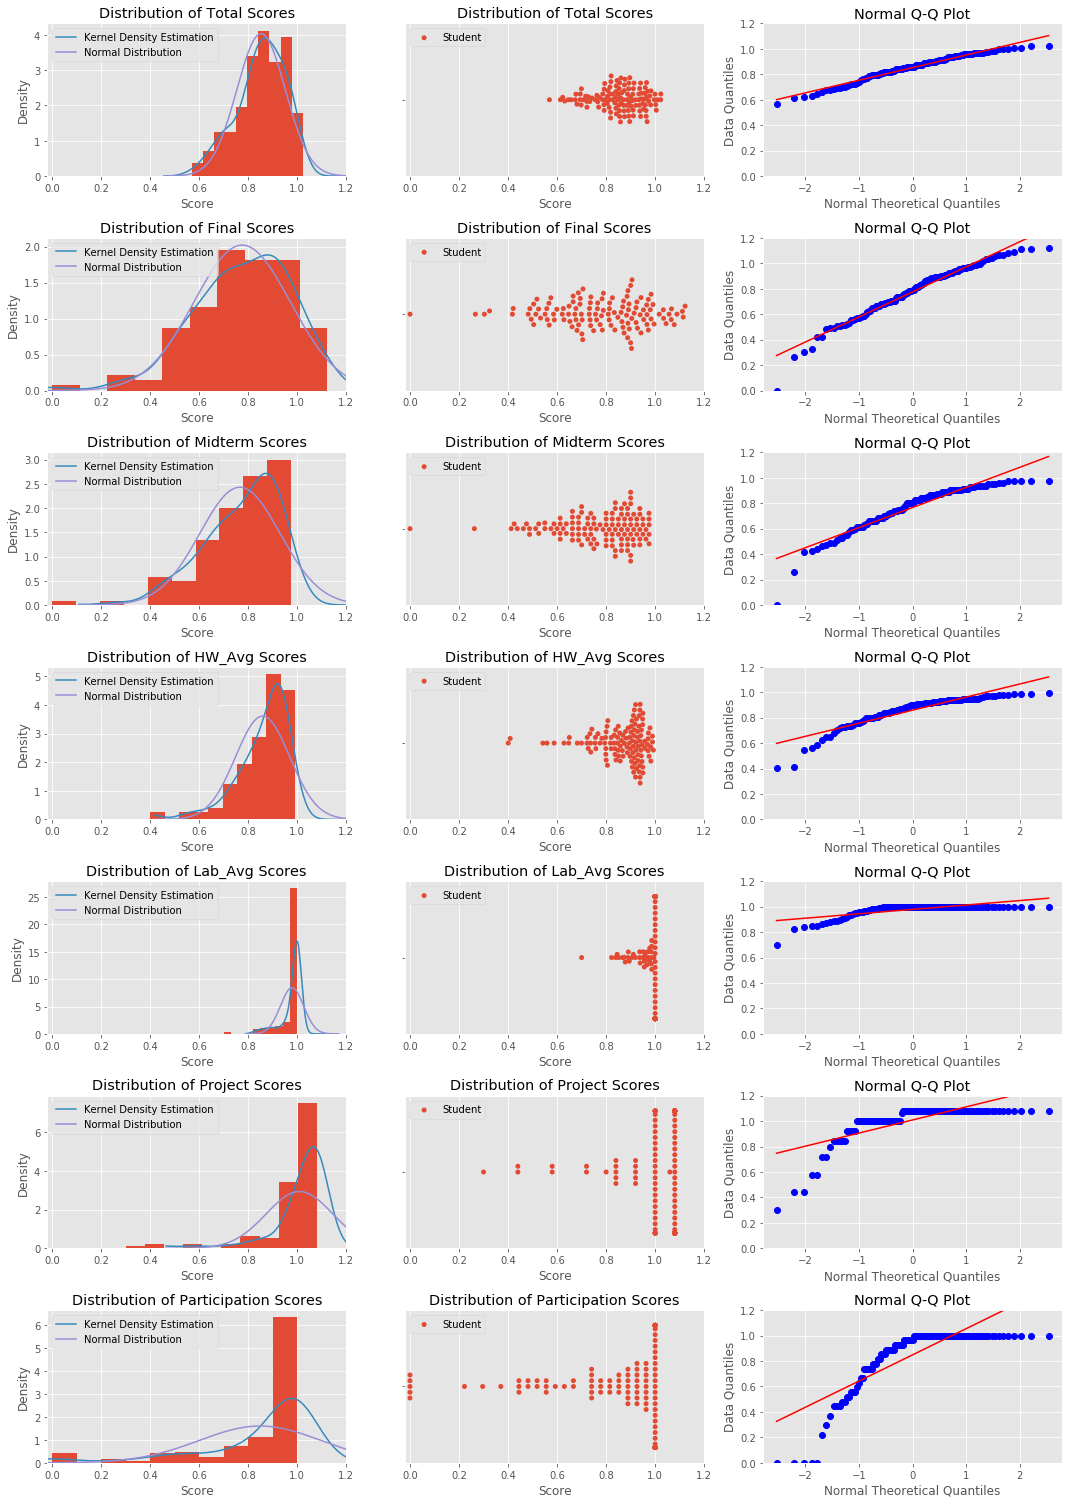

In [43]:
criteria = 'Total','Final','Midterm','HW_Avg','Lab_Avg','Project','Participation'
ncriteria = len(criteria)

plt.figure(figsize=(15,3*nrows))
score_range = [-.02,1.2]

for i, criterion in enumerate(criteria,1):
    scores = df[criterion]
    mean, sd = np.mean(scores), np.std(scores)
    
    # Histogram
    plt.subplot(ncriteria, 3, 3*i-2)
    scores.hist(density=True)
    x = np.linspace(mean-4*sd, mean+4*sd,1000)
    plt.plot(x, stats.gaussian_kde(scores)(x), label='Kernel Density Estimation')
    plt.plot(x, stats.norm.pdf(x, loc=mean, scale=sd), label='Normal Distribution')
    plt.title('Distribution of {} Scores'.format(criterion))
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.xlim(score_range)
    plt.legend(loc='upper left')
    
    # Swarm Plot
    plt.subplot(ncriteria, 3, 3*i-1)
    sns.swarmplot(scores, label='Student')
    plt.title('Distribution of {} Scores'.format(criterion))
    plt.xlabel("Score")
    plt.xlim(score_range)
    plt.legend(loc='upper left')

    # Q-Q Plot
    plt.subplot(ncriteria, 3, 3*i)
    stats.probplot(scores, plot=plt)
    plt.title('Normal Q-Q Plot')
    plt.xlabel('Normal Theoretical Quantiles')
    plt.ylabel('Data Quantiles')
    plt.ylim([0,1.2])
    
plt.tight_layout()

The `Total` and `Final` scores appear to be normally distributed. The `Midterm`, `HW_Avg`, `Lab_Avg`, `Project`, and `Participation` scores appear to have "backward" variations of the exponential distribution. It may be the case that these scores inherently come from an approximately normal distribution but that the top students' scores are "smooshed" along the upper bound. For example, it's impossible for students to have over a 1.0 `Participation` score, so the top students' scores appear to be condensed into a small range along the upper bound.

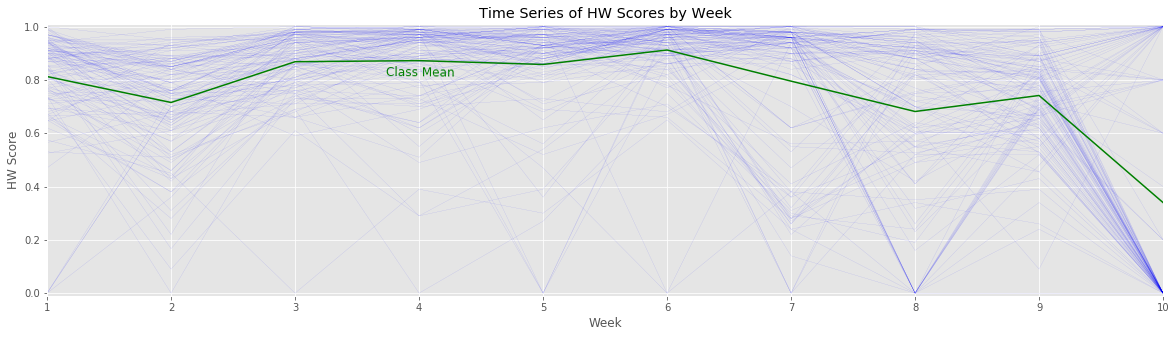

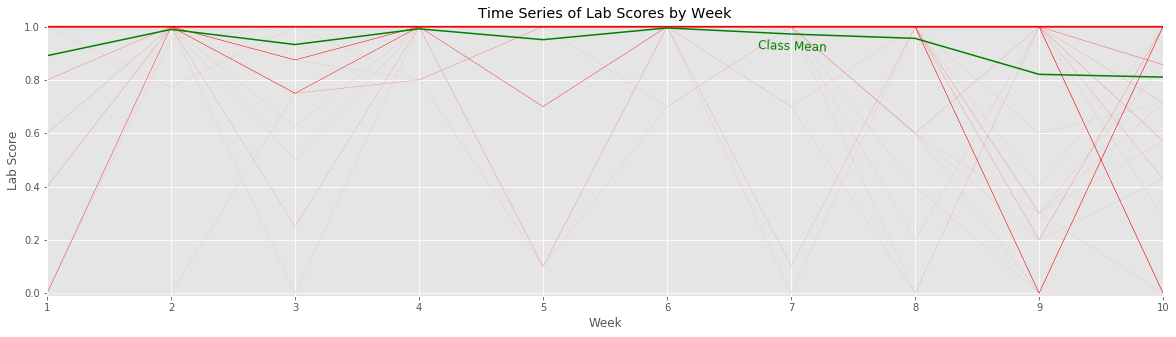

In [13]:
hw_mean, lab_mean = tuple(map(np.mean,zip(*df['HW']))), tuple(map(np.mean,zip(*df['Lab'])))

texts = []
for assignment, color, mean in ('HW','b',hw_mean), ('Lab','r',lab_mean):
    plt.figure(figsize=(20,5))
    
    # Student scores
    for i in range(n):
        plt.plot(weeks, df.iloc[i][assignment], color, lw=.05)
        
    # Averages (and associated labels)
    plt.plot(weeks, mean, 'g')
    texts.append(plt.text(0, 0, 'Class Mean', color='g', size='large'))
    
    plt.title('Time Series of {} Scores by Week'.format(assignment))
    plt.xlabel('Week')
    plt.ylabel('{} Score'.format(assignment))
    plt.axis([1,10,-.01,1.01])
    plt.xticks(weeks)
        
plt.setp(texts[0], x=3.73, y=.815, rotation=-.5)
plt.setp(texts[1], x=6.73, y=.918, rotation=-2);

We can see that some weeks have drastic drops in homework and/or lab scores. I can offer the following plausible explanations:
- **Lab 1**: **Lab 1** was due on only the third day of the quarter and many students may have forgotten to complete the lab assignment.
- **HW 1**: **HW 1** served as a "warm-up" assignment, but the course staff graded **HW 2** much more aggressively, especially on doctests and code style, something many students tended to overlook.
- **HW 8**: **HW 8** was considered the most difficult homework assignment (covering OOP, recursion, linked lists, queues, and circular arrays all in one assignment) and many students were unable to complete the assignment on time. **HW 7** was also difficult (covering time complexity and pandas).
- **HW 10**: As per the syllabus, **HW 10** was optional. 
- **Lab 10**: As per the syllabus, the lowest lab score was dropped and many students may have used the opportunity to skip **Lab 10**. This may also explain **Lab 9**.

Explanations are based off of my personal experience as well as what I observed during lectures and on the class' [Piazza](https://piazza.com) forum.

## Correlation Between Students

Academic integrity is something universities work hard to enforce and UCSD is no exception (I actually work for UCSD's Academic Integrity Office). For programming courses, special attention is given to programming assignments, as it's effortless for students to copy code from one another.

We'll use an algorithmic approach to explore correlations between students' homework scores and to see if the correlations indicate any signs of cheating.

We'll first generate all the possible student pairings (i.e. combinations of size 2) from our class. For example, in a class of three students (students A, B, and C), the possible pairings are:
1. A and B.
- B and C.
- A and C.

The number of the possible pairings for our class will be much larger.

For each pairing, we'll then calculate and store the correlation coefficient (via Pearson's r) between the two students' homework scores.

In [14]:
correlations = {}
for a, b in combinations(range(n),2):  # Generates combinations of size 2 from 0, 1, ..., n-1
    correlations[a,b] = stats.pearsonr(df.iloc[a]['HW'], df.iloc[b]['HW'])[0]
npairings = len(correlations)
print('There are {} possible student pairings from our class of {} students.'.format(npairings, n))

There are 7503 possible student pairings from our class of 123 students.


Proof: $\binom{123}{2}=\frac{123!}{2!(123-2)!}=7503$.

Now that we have all of the possible student pairings and their associated correlations, we'll store this data in a table.

In [15]:
df_r = pd.DataFrame(list(correlations.items()), columns=['Pairing','r'])
df_r['HWs']     = df_r['Pairing'].apply(lambda pair: (df.iloc[pair[0]]['HW'], df.iloc[pair[1]]['HW']))
df_r['Pairing'] = df_r['Pairing'].apply(lambda pair: (df.iloc[pair[0]]['ID'], df.iloc[pair[1]]['ID']))
df_r = df_r[['r','Pairing','HWs']].sort_values('r',ascending=False).reset_index(drop=True)
df_r.index += 1
df_r

,r,Pairing,HWs
1,0.9970,"(alc643, vlg015)","((0.97, 0.85, 0.94, 0.96, 0.96, 0.9, 0.96, 0.88, 0.81, 0.0), (0.97, 0.87, 0.99, 0.97, 0.97, 0.97..."
2,0.9960,"(cepdvrrg, h4gldc)","((0.81, 0.88, 0.9, 0.99, 0.94, 0.97, 1.0, 1.0, 0.755, 0.0), (0.83, 0.93, 0.92, 0.99, 0.98, 1.0, ..."
3,0.9943,"(fdr.fkhqcl97, bxc530)","((0.92, 0.79, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 0.92, 1.0), (0.9, 0.7, 0.99, 1.0, 0.99, 0.98, 1.0, ..."
4,0.9941,"(da005732, da005756)","((0.0, 0.7, 0.81, 0.97, 0.99, 1.0, 0.98, 0.94, 0.81, 1.0), (0.0, 0.7, 0.81, 0.98, 0.96, 0.91, 0...."
...,...,...,...
7500,-0.6799,"(gko011, lvuxelr)","((1.0, 0.95, 0.98, 0.92, 1.0, 1.0, 0.96, 0.99, 0.98, 1.0), (0.565, 0.68, 0.66, 0.84, 0.47, 0.0, ..."
7501,-0.7348,"(odpffduw, odc021)","((0.855, 0.87, 0.8, 0.97, 0.93, 0.89, 0.94, 0.94, 0.94, 1.0), (0.95, 0.51, 0.69, 0.0, 0.27, 0.75..."
7502,-0.7649,"(vjp002, lvuxelr)","((0.88, 0.76, 0.86, 0.9, 0.9, 1.0, 0.95, 0.97, 0.87, 1.0), (0.565, 0.68, 0.66, 0.84, 0.47, 0.0, ..."
7503,-0.8393,"(odpffduw, fueurgb)","((0.855, 0.87, 0.8, 0.97, 0.93, 0.89, 0.94, 0.94, 0.94, 1.0), (0.76, 0.65, 0.79, 0.49, 0.62, 0.7..."


The table (stored in `df_r`) is ordered by `r`. Row indices reflect the ranking of `r` from strongest, positive correlation to strongest, negative correlation.

**Columns:**
1. `r` contains the correlation associated with each student pairing.
- `Pairing` contains the `ID`'s of the two students.
- `HWs` contains the `HW` scores of the two students.

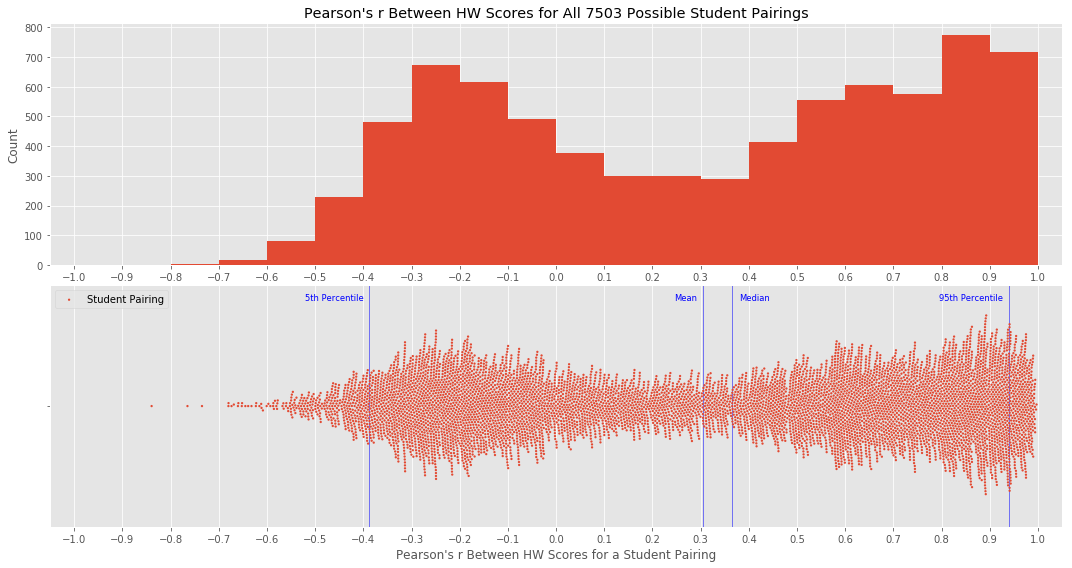

In [16]:
plt.figure(figsize=(15,8))
r = df_r['r']
rrange = [-1.05,1.05]
rticks = np.arange(-1,1.1,.1)

plt.subplot(211)
plt.hist(r, bins=rticks)
plt.title("Pearson's r Between HW Scores for All {} Possible Student Pairings".format(npairings))
plt.ylabel('Count')
plt.xlim(rrange)
plt.xticks(rticks)

plt.subplot(212)
sns.swarmplot(r, size=2.3, label='Student Pairing')
plt.xlabel("Pearson's r Between HW Scores for a Student Pairing")
plt.xlim(rrange)
plt.xticks(rticks)
plt.legend()

measures = (
    ('Mean',  np.mean(r), .245),
    ('Median', np.median(r), .38),
    ('5th Percentile', np.percentile(r,5), -.52),
    ('95th Percentile', np.percentile(r,95), .795)
)

for measure in measures:
    plt.axvline(measure[1], c='b', lw=.5)
    plt.text(measure[2], -.44, measure[0], color='b', size='small')

plt.tight_layout(h_pad=0)

We can see two clusters of r's: one with weak, negative correlations and the other with strong, positive correlations. The distribution appears to be centered around a moderately strong, positive correlation. In general, we can see a very wide distribution of r's.

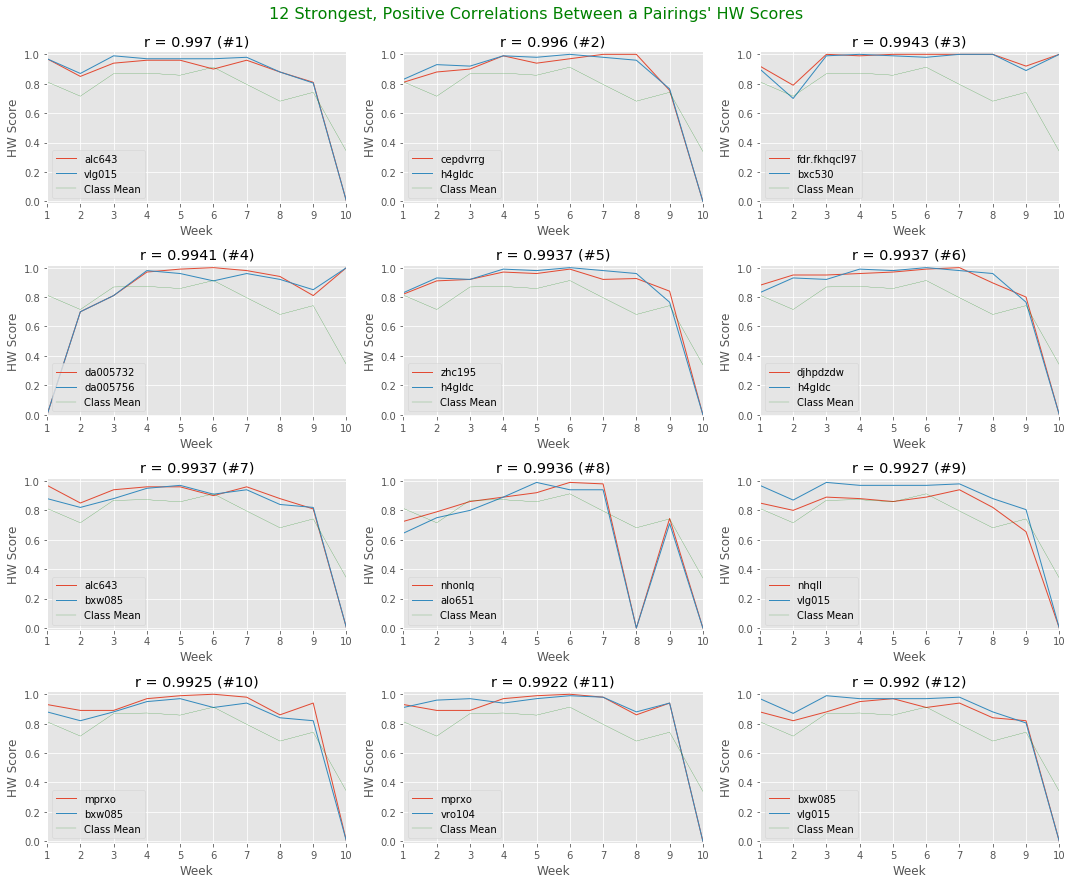

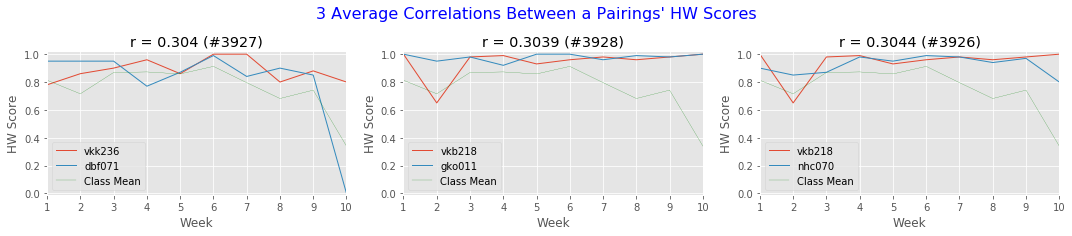

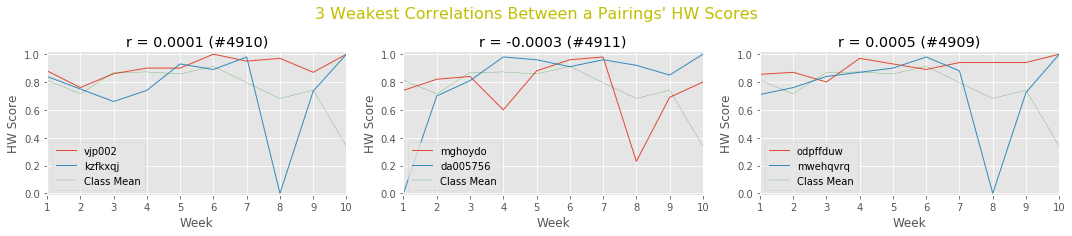

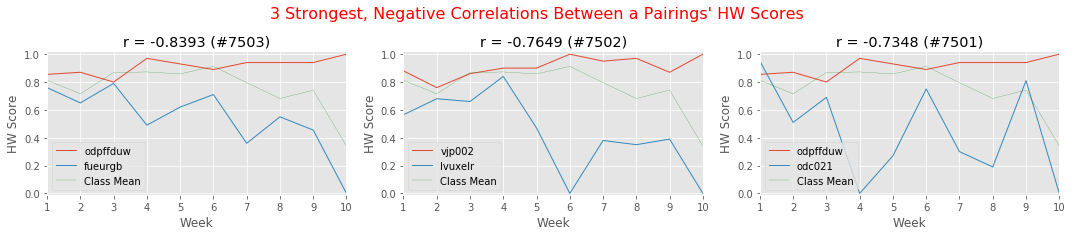

In [17]:
r_pos  = df_r[:12], 'Strongest, Positive', 'g', 1.02
r_avg  = df_r.assign(ab=abs(r-np.mean(r))).sort_values('ab').drop('ab',axis=1)[:3], 'Average', 'b', 1.08
r_weak = df_r.assign(ab=abs(r)).sort_values('ab').drop('ab',axis=1)[:3], 'Weakest', 'y', 1.08
r_neg  = df_r[::-1][:3], 'Strongest, Negative', 'r', 1.08

for group, title, color, y in r_pos, r_avg, r_weak, r_neg:
    ngroup = group.shape[0]
    plt.figure(figsize=(15,ngroup))
    plt.suptitle("{} {} Correlations Between a Pairings' HW Scores".format(ngroup, title), color=color, size=16, y=y)
    for i in range(ngroup):
        pair = group.iloc[i]
        plt.subplot(ngroup/3,3,i+1)
        plt.plot(weeks, pair['HWs'][0], lw=1, label=pair['Pairing'][0])
        plt.plot(weeks, pair['HWs'][1], lw=1, label=pair['Pairing'][1])
        plt.plot(weeks, hw_mean, 'g', lw=.2, label='Class Mean')

        plt.title('r = {} (#{})'.format(round(pair['r'],4), pair.name))
        plt.xlabel('Week')
        plt.ylabel('HW Score')
        plt.axis([1,10,-.01,1.02])
        plt.xticks(weeks)
        plt.legend(loc='lower left')   
    plt.tight_layout()

## Predicting Final Exam Scores

### Multiple Linear Regression

In [18]:
# predict final: multiple linear regression, random forest

In [19]:
X, y = df[['Midterm','HW_Avg','Lab_Avg','Project','Participation']], df['Final']

In [20]:
model = LinearRegression()
results = model.fit(X, y)
print(model.intercept_, model.coef_)

-0.6538007347348014 [0.55088711 0.37406344 0.47832822 0.19710172 0.02207036]


In [21]:
np.zeros((10, 2)).T

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

graph of scatterplot and correlations (heatmap)

In [22]:
stats.pearsonr(df['Lab_Avg'], df['Final'])

(0.2632465985076471, 0.0032630222369859968)

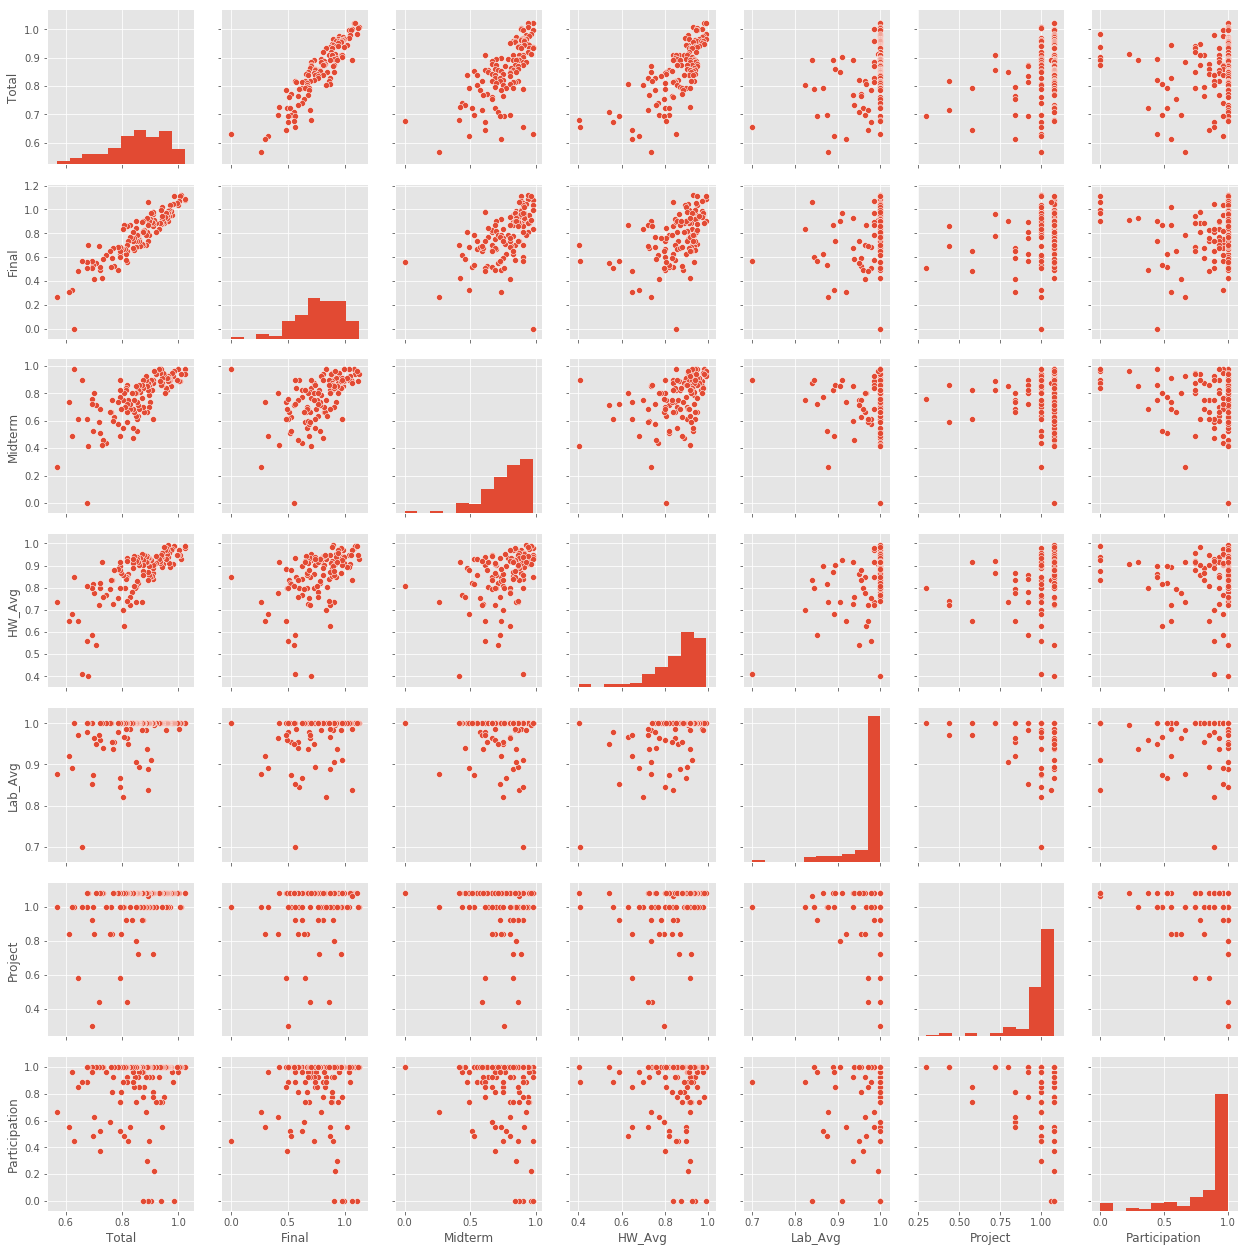

In [23]:
 sns.pairplot(df) # with correlations

In [24]:
sm.OLS(df['Final'], sm.add_constant(df[['Midterm','HW_Avg','Lab_Avg','Project']])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Final   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     19.90
Date:                Wed, 05 Sep 2018   Prob (F-statistic):           1.52e-12
Time:                        22:04:52   Log-Likelihood:                 56.722
No. Observations:                 123   AIC:                            -103.4
Df Residuals:                     118   BIC:                            -89.38
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6555      0.327     -2.005      0.047      -1.303      -0.008
Midterm        0.5465      0.095      5.764      0.000       0.359       0.734
HW_Avg         0.3710      0.171      2.168      0.032       0.032       0.710
Lab_Avg        0.5076      0.353      1.437      0.153      -0.192       1.207
Project        0.1949      0.110      1.777      0.078      -0.022       0.412
==============================================================================
Omnibus:                       64.875   Durbin-Watson:                   1.449
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              385.275
Skew:                          -1.690   Prob(JB):                     2.18e-84
Kurtosis:                      10.984   Cond. No.                         70.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
test = df[:4]
model = sm.OLS(test['Final'], sm.add_constant(test[['Midterm','HW_Avg','Lab_Avg','Project','Total','Participation']])).fit()

In [ ]:
# parsimmonous

In [ ]:
# backward selection

In [ ]:
# Assumptions
# Prediction intervals
sm.OLS(df['Final'], sm.add_constant(df[['Midterm','HW_Avg','Lab_Avg','Project','Participation']])).fit().summary()

Conditions:
- Linearity (Between Each Predictor and the Criterion)
- Normality (of Residuals)
- Homoscedasticity (of Residuals)

There must be a linear relationship between the outcome variable and the independent variables.  Scatterplots can show whether there is a linear or curvilinear relationship.
Multivariate Normality–Multiple regression assumes that the residuals are normally distributed.
No Multicollinearity—Multiple regression assumes that the independent variables are not highly correlated with each other.  This assumption is tested using Variance Inflation Factor (VIF) values.
Homoscedasticity–This assumption states that the variance of error terms are similar across the values of the independent variables.  A plot of standardized residuals versus predicted values can show whether points are equally distributed across all values of the independent variables.
Intellectus Statistics automatically includes the assumption tests and plots when conducting a regression.

1. narrow down variables
2. check assumptions

OLS  
LAD  
Backward Elimination Model Selection (via t-test) OLS  
AIC Model Selection OLS https://link.springer.com/content/pdf/10.3758/BF03206482.pdf  
Ridge  
Lasso  
Elastic Net  

Multicollinearity, suggesting elimination or ridge  
Curious to see what osmeone would have gotten in the class, can extend to other quarters but not same distributions.  
Standardizing predictors may resolve issues of differing means and SD's, but will not solve the issue of different weights or how each predictor predicts. Maybe participation will be more important later (e.g. giving away exam questions).

### Random Forest

## Bibliography
1. Wagenmakers, EJ. & Farrell, S. Psychonomic Bulletin & Review (2004) 11: 192. https://doi.org/10.3758/BF03206482